<a href="https://colab.research.google.com/github/kaczquszka/kwiatuszki/blob/main/model_marta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [602]:
import pandas as pd
from datasets import Dataset, DatasetDict
dataset = pd.read_csv("answers_tab.csv", sep ="\t")

In [603]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer, TrainingArguments, Trainer

In [604]:
id2label = {0:'negative', 1:'neutral', 2:'postive'}
label2id = {'negative': 0, 'neutral':1, 'positive':2}
model_checkpoint = 'distilbert-base-uncased'
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels = 3, id2label = id2label, label2id=label2id)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [605]:
dataset = Dataset.from_dict({'text': dataset.iloc[:,0], 'label':dataset.iloc[:,-1]})
dataset = DatasetDict({'train': dataset})

In [606]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1061
    })
})

In [607]:
from collections import Counter

Counter(dataset['train']["label"])

Counter({'positive': 388, 'negative': 352, 'neutral': 321})

In [608]:
def mapping(example):
  example['label'] = label2id[example['label']]
  return example

In [609]:
dataset = dataset['train'].map(mapping)

Map:   0%|          | 0/1061 [00:00<?, ? examples/s]

In [610]:
Counter(dataset['label'])

Counter({2: 388, 0: 352, 1: 321})

In [611]:
dataset

Dataset({
    features: ['text', 'label'],
    num_rows: 1061
})

In [612]:
from sklearn.model_selection import train_test_split
dataset = dataset.train_test_split( test_size = 0.2, seed = 67)
#20% do testu

In [613]:
dataset
#https://www.learnhuggingface.com/notebooks/hugging_face_text_classification_tutorial?

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 848
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 213
    })
})

In [614]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [615]:
tokenizer('no i dont like it')
tokenizer.model_max_length = 100 #tylko 100 bo mamy krótkie zdania, być może trzeba będzie rozważyć wydłużenie
tokenizer.convert_ids_to_tokens(tokenizer('Marta').input_ids)

['[CLS]', 'marta', '[SEP]']

In [616]:
def tokenize_datset(example):
  return tokenizer(example['text'], truncation=True, padding=True)

In [617]:
tokenized_dataset = dataset.map(tokenize_datset, batched =True, batch_size=1000)

Map:   0%|          | 0/848 [00:00<?, ? examples/s]

Map:   0%|          | 0/213 [00:00<?, ? examples/s]

In [618]:
tokenized_dataset.keys()

dict_keys(['train', 'test'])

In [619]:
import evaluate
import numpy as np
accuracy = evaluate.load('accuracy')

In [620]:
def compute_accuracy(predictions_and_labels: tuple[np.array, np.array]):
  predictions, labels = predictions_and_labels
  if (len(predictions.shape)>=2):
    predictions = np.argmax(predictions, axis=1)
  return accuracy.compute(predictions=predictions, references=labels)

In [621]:
# Create example list of predictions and labels
example_predictions_all_correct = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
example_predictions_one_wrong = np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0])
example_labels = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

# Test the function
print(f"Accuracy when all predictions are correct: {compute_accuracy((example_predictions_all_correct, example_labels))}")
print(f"Accuracy when one prediction is wrong: {compute_accuracy((example_predictions_one_wrong, example_labels))}")

Accuracy when all predictions are correct: {'accuracy': 1.0}
Accuracy when one prediction is wrong: {'accuracy': 0.9}


In [622]:
model

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [623]:
learn_rate = 0.00002
epochs = 5
batch_train = 20
batch_eval = 20

In [624]:
from pathlib import Path
m_dir = Path("models")
m_dir.mkdir(exist_ok = True)
model_name = ('fine-tuned-on-1000-answers-distilbert-base-uncased')

model_directory = Path(m_dir,model_name)
model_directory

PosixPath('models/fine-tuned-on-1000-answers-distilbert-base-uncased')

In [625]:
training_args = TrainingArguments(
    output_dir = model_directory,
    learning_rate = learn_rate,
    per_device_train_batch_size = batch_train,
    per_device_eval_batch_size	= batch_eval,
    num_train_epochs = epochs,
    eval_strategy = 'epoch',
    seed = 67,
    save_strategy ='epoch',
    logging_strategy = 'epoch',
    report_to = 'none'
)

In [626]:
trainer = Trainer(
    model = model,
    args=training_args,
    train_dataset = tokenized_dataset['train'],
    eval_dataset = tokenized_dataset['test'],
    tokenizer = tokenizer,
    compute_metrics = compute_accuracy)

/tmp/ipython-input-2655332214.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [627]:
results = trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.024400,0.789559,0.723005
2,0.641300,0.493740,0.830986
3,0.410200,0.414126,0.826291
4,0.309600,0.379977,0.854460
5,0.240600,0.377509,0.849765


In [628]:
trainer.save_model(model_directory)

In [629]:
log_history = trainer.state.log_history[:-1]

In [630]:
log_history[:4]

[{'loss': 1.0244,
  'grad_norm': 6.4576849937438965,
  'learning_rate': 1.6093023255813955e-05,
  'epoch': 1.0,
  'step': 43},
 {'eval_loss': 0.7895586490631104,
  'eval_accuracy': 0.7230046948356808,
  'eval_runtime': 0.2327,
  'eval_samples_per_second': 915.484,
  'eval_steps_per_second': 47.279,
  'epoch': 1.0,
  'step': 43},
 {'loss': 0.6413,
  'grad_norm': 4.973980903625488,
  'learning_rate': 1.2093023255813954e-05,
  'epoch': 2.0,
  'step': 86},
 {'eval_loss': 0.4937404990196228,
  'eval_accuracy': 0.8309859154929577,
  'eval_runtime': 0.2042,
  'eval_samples_per_second': 1043.041,
  'eval_steps_per_second': 53.866,
  'epoch': 2.0,
  'step': 86}]

In [631]:
loss_history=[]
eval_history=[]

for item in log_history:
  key = item.keys()
  if any('eval_loss' in x for x in key):
    eval_history.append(item)
  else:
    loss_history.append(item)

In [632]:
loss_df = pd.DataFrame(loss_history)
eval_df = pd.DataFrame(eval_history)

In [633]:
loss_df

,loss,grad_norm,learning_rate,epoch,step
0,1.0244,6.457685,1.609302e-05,1.0,43
1,0.6413,4.973981,1.209302e-05,2.0,86
2,0.4102,1.788231,8.093023e-06,3.0,129
3,0.3096,11.013946,4.093023e-06,4.0,172
4,0.2406,11.543392,9.302326e-08,5.0,215


In [634]:
eval_df

,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,epoch,step
0,0.789559,0.723005,0.2327,915.484,47.279,1.0,43
1,0.493740,0.830986,0.2042,1043.041,53.866,2.0,86
2,0.414126,0.826291,0.2364,900.878,46.524,3.0,129
3,0.379977,0.854460,0.2159,986.671,50.955,4.0,172
4,0.377509,0.849765,0.3181,669.566,34.579,5.0,215


In [635]:
best_epoch_acc = eval_df['eval_accuracy'].idxmax()
smallest_val_loss = eval_df['eval_loss'].idxmin()
smallest_val_loss


4

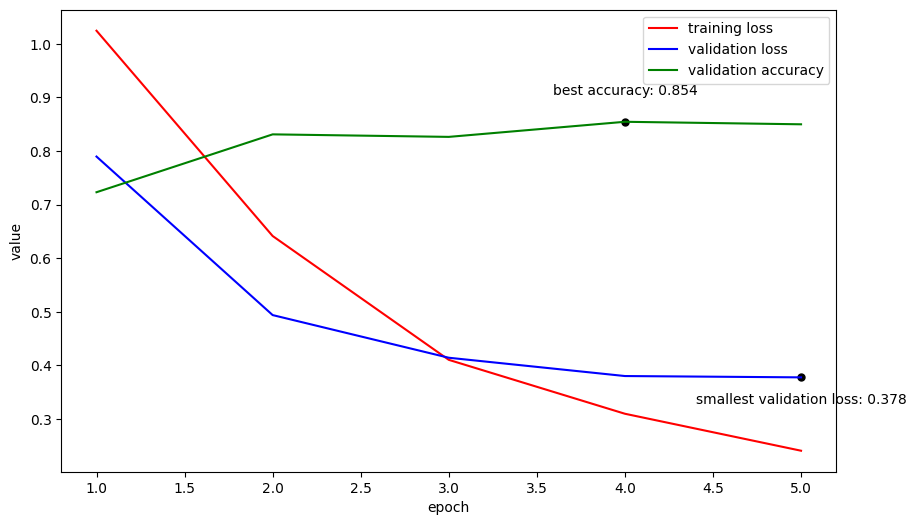

In [636]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(loss_df['epoch'], loss_df['loss'], color='red', label='training loss')
plt.plot(eval_df['epoch'], eval_df['eval_loss'], color='blue',label='validation loss')
plt.plot(eval_df['epoch'], eval_df['eval_accuracy'], color='green', label='validation accuracy')
plt.scatter(best_epoch_acc+1, eval_df.loc[best_epoch_acc]['eval_accuracy'], s=25, color='black')
plt.text(best_epoch_acc+1, eval_df.loc[best_epoch_acc]['eval_accuracy']+ 0.05, f"best accuracy: {(eval_df.loc[best_epoch_acc]['eval_accuracy']):.3f}", ha='center')
plt.scatter(smallest_val_loss+1, eval_df.loc[smallest_val_loss]['eval_loss'], s=25, color='black')
plt.text(smallest_val_loss+1, eval_df.loc[smallest_val_loss]['eval_loss']- 0.05, f"smallest validation loss: {(eval_df.loc[smallest_val_loss]['eval_loss']):.3f}", ha='center')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('value')
plt.show()

In [700]:
checkpoint_path = "/content/models/fine-tuned-on-1000-answers-distilbert-base-uncased/checkpoint-172"
repo_name = "kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased"


best_model = AutoModelForSequenceClassification.from_pretrained(checkpoint_path)
tokenizer = AutoTokenizer.from_pretrained(checkpoint_path)

In [701]:
from google.colab import userdata
model_upload_url = best_model.push_to_hub(
    repo_id=repo_name,
    commit_message="Uploading model",
    token = userdata.get('hug_token')
)
tokenizer.push_to_hub(
    repo_id=repo_name,
    commit_message="Uploading tokenizer",
    token=userdata.get('hug_token')
)

README.md: 0.00B [00:00, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...xt1phcy/model.safetensors:   9%|9         | 25.1MB /  268MB            

CommitInfo(commit_url='https://huggingface.co/kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased/commit/b5d91993be06ec6043d5fd67e28c2603ad25c466', commit_message='Uploading tokenizer', commit_description='', oid='b5d91993be06ec6043d5fd67e28c2603ad25c466', pr_url=None, repo_url=RepoUrl('https://huggingface.co/kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased', endpoint='https://huggingface.co', repo_type='model', repo_id='kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased'), pr_revision=None, pr_num=None)

In [641]:
predictions_all = trainer.predict(tokenized_dataset["test"])
prediction_values = predictions_all.predictions
prediction_metrics = predictions_all.metrics

In [671]:
print(tokenized_dataset['test']['text'])

Column(['Healthy = more energy.', 'Too hot there probably, I burn easy.', 'I’d watch not join.', 'I try to eat healthy but when project deadlines come closer, I just order pizza and forget about vegetables.', 'Work better under stress ngl.'])


In [ ]:
import torch
predictions= np.array(torch.softmax(torch.tensor(prediction_values), dim=1))
predictions
for row in range(predictions.shape[0]):
    print(tokenized_dataset['test']['text'][row], ", ".join(f"{label}: {predictions[row][id]:.3f}" for id, label in id2label.items()))




In [702]:
from transformers import pipeline
model_path ='kaczquszka/fine-tuned-on-1000-answers-distilbert-base-uncased'
BATCH_SIZE = 10
classify_sentiment = pipeline(task='text-classification',model = model_path, batch_size = BATCH_SIZE, top_k =3)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

Device set to use cuda:0


In [705]:
sentences = [
    "I whipped up a fresh batch of code, but it seems to have a syntax error.",
    "We need to marinate these ideas overnight before presenting them to the client.",
    "The new software is definitely a spicy upgrade, taking some time to get used to.",
    "Her social media post was the perfect recipe for a viral sensation.",
    "He served up a rebuttal full of facts, leaving his opponent speechless.",
    "The team needs to simmer down a bit before tackling the next challenge.",
    "The presentation was a delicious blend of humor and information, keeping the audience engaged.",
    "A beautiful array of fake wax foods (shokuhin sampuru) in the front of a Japanese restaurant.",
    "Daniel Bourke is really cool :D",
    "My favoruite food is biltong!"
]

classify_sentiment(sentences)

[[{'label': 'neutral', 'score': 0.7315495610237122},
  {'label': 'negative', 'score': 0.22195352613925934},
  {'label': 'postive', 'score': 0.046496834605932236}],
 [{'label': 'postive', 'score': 0.4854711890220642},
  {'label': 'neutral', 'score': 0.4570074677467346},
  {'label': 'negative', 'score': 0.05752135440707207}],
 [{'label': 'neutral', 'score': 0.5145958065986633},
  {'label': 'postive', 'score': 0.4468866288661957},
  {'label': 'negative', 'score': 0.03851759433746338}],
 [{'label': 'postive', 'score': 0.9233018159866333},
  {'label': 'neutral', 'score': 0.045593246817588806},
  {'label': 'negative', 'score': 0.031104957684874535}],
 [{'label': 'negative', 'score': 0.5416643023490906},
  {'label': 'neutral', 'score': 0.2637428045272827},
  {'label': 'postive', 'score': 0.1945928931236267}],
 [{'label': 'neutral', 'score': 0.6426798701286316},
  {'label': 'negative', 'score': 0.18291564285755157},
  {'label': 'postive', 'score': 0.17440447211265564}],
 [{'label': 'postive', 

In [ ]:
testing_token = AutoTokenizer.from_pretrained(model_path)

inputs = testing_token(sentences, return_tensors ='pt', truncation=True, padding=True)
inputs

In [696]:
testing_model = AutoModelForSequenceClassification.from_pretrained(model_path)

In [697]:
  testing_model(**inputs)

SequenceClassifierOutput(loss=None, logits=tensor([[ 0.3355,  1.3414, -1.4563],
        [-1.5973,  0.4246,  0.7527],
        [-1.7568,  0.8431,  0.8328],
        [-1.4352, -1.1234,  2.0537],
        [ 0.7146, -0.2980, -0.5951],
        [-0.1679,  0.7832, -0.5814],
        [-1.6753, -0.8246,  2.1727],
        [-1.4380, -0.8827,  2.0119],
        [-1.6863, -0.9212,  2.3012],
        [ 1.0652, -0.6942, -0.4046]], grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)